# XAI CODE DEMO

## Explainable AI Specialization on Coursera



# Local Explanations 🏘️

If high latency occurs when running this notebook in Coursera, feel free to Open in Google Colab:

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/explainable-machine-learning/explainable-ml/blob/main/local_explanations.ipynb)


Table of Contents
* [LIME 🍋](https://colab.research.google.com/drive/1aBZSreILCbF3x7f5PIIlA3eNTmxoyzL7#scrollTo=nTO5RNakdVPW&line=19&uniqifier=1)
* [Anchors ⚓️](https://colab.research.google.com/drive/1aBZSreILCbF3x7f5PIIlA3eNTmxoyzL7#scrollTo=CzDNNmMrdizl&line=17&uniqifier=1)
* [SHAP 🎲](https://colab.research.google.com/drive/1aBZSreILCbF3x7f5PIIlA3eNTmxoyzL7#scrollTo=kRWoDl1SdQbK&line=22&uniqifier=1)
* [ICE plots 🧊](https://colab.research.google.com/drive/1aBZSreILCbF3x7f5PIIlA3eNTmxoyzL7#scrollTo=8WVOuglNdgEJ&line=9&uniqifier=1)

First, we will install the necessary libraries. In addition to numpy and pandas, we will use the following libraries:


*   scikit-learn (Model, ICE plots)
*   shap (SHAP)
*   lime (LIME)
*   anchor-exp (Anchors)

In [1]:
!pip install numpy==1.25.2 pandas==2.0.3 matplotlib==3.7.1 scikit-learn==1.2.2 lime==0.2.0.1 anchor-exp==0.0.2.0 shap==0.45.1 xgboost==1.7.5

In [4]:
pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 72.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.0
    Uninstalling pip-24.0:
      Successfully uninstalled pip-24.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Models
import xgboost
from sklearn.model_selection import train_test_split

# XAI
import shap
import lime
from anchor import anchor_tabular
from sklearn.inspection import PartialDependenceDisplay

np.random.seed(1)

**Dataset**
We will use the classic [UCI adult income dataset](https://archive.ics.uci.edu/dataset/2/adult). This is a classification task to predict if people made over $50k in the 1990's.

**Model**
We will train an XGBoost classifier model with default parameters for explanatory purposes. We are also performing a 50-50 train/test split for optimization purposes.

In [3]:
# Load Data from shap library
X,y = shap.datasets.adult()

The model being trained below may take a few minutes to run.

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Train XGBoost model
model = xgboost.XGBClassifier()
model.fit(X_train, y_train)

For LIME and Anchors, we need to define some characteristics of our data:

In [ ]:
feature_names = ["Age", "Workclass",
                 "Education-Num", "Marital Status", "Occupation",
                 "Relationship", "Race", "Sex", "Capital Gain",
                 "Capital Loss", "Hours per week", "Country"]

categorical_features = ["Workclass", "Marital Status", "Occupation", "Relationship", "Race", "Sex", "Country"]

class_names = ['<=50K', '>50K']

categorical_names = {
    1: ['Private', 'Self-emp-not-inc', 'Self-emp-inc', 'Federal-gov', 'Local-gov', 'State-gov', 'Without-pay', 'Never-worked'],  # Workclass
    3: ['Married-civ-spouse', 'Divorced', 'Never-married', 'Separated', 'Widowed', 'Married-spouse-absent', 'Married-AF-spouse'],  # Marital Status
    4: ['Tech-support', 'Craft-repair', 'Other-service', 'Sales', 'Exec-managerial', 'Prof-specialty', 'Handlers-cleaners', 'Machine-op-inspct', 'Adm-clerical', 'Farming-fishing', 'Transport-moving', 'Priv-house-serv', 'Protective-serv', 'Armed-Forces'],  # Occupation
    5: ['Wife', 'Own-child', 'Husband', 'Not-in-family', 'Other-relative', 'Unmarried'],  # Relationship
    6: ['White', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other', 'Black'],  # Race
    7: ['Female', 'Male'],  # Sex
    11: ['United-States', 'Cambodia', 'England', 'Puerto-Rico', 'Canada', 'Germany', 'Outlying-US(Guam-USVI-etc)', 'India', 'Japan', 'Greece', 'South', 'China', 'Cuba', 'Iran', 'Honduras', 'Philippines', 'Italy', 'Poland', 'Jamaica', 'Vietnam', 'Mexico', 'Portugal', 'Ireland', 'France', 'Dominican-Republic', 'Laos', 'Ecuador', 'Taiwan', 'Haiti', 'Columbia', 'Hungary', 'Guatemala', 'Nicaragua', 'Scotland', 'Thailand', 'Yugoslavia', 'El-Salvador', 'Trinadad&Tobago', 'Peru', 'Hong', 'Holand-Netherlands']  # Country
}

## LIME 🍋

Local interpretable model-agnostic explanations (LIME) [[Paper, 2016]](https://arxiv.org/abs/1602.04938)

Interpretable models that are used to explain individual predictions of black box machine learning model

**LIME Process:**
1.   Select instance of interest
2.   Perturb your dataset and get black box predictions for perturbed samples
3.   Generate a new dataset consisting of perturbed samples (variations of your data) and the corresponding predictions
4.   Train an interpretable model, weighted by the proximity of sampled instances to the instance of interest
5.   Interpret the local model to explain prediction

As opposed to LIME for text, tabular explainers need a training set. This is because statistics are computed on each feature. If the feature is numerical, we compute the mean and std, and discretize it into quartiles. If the feature is categorical, we compute the frequency of each value. This is used to scale the data, so that we can meaningfully compute distances when the attributes are not on the same scale and to sample perturbed instances - which we do by sampling from a Normal(0,1), multiplying by the std and adding back the mean.


LIME uses an exponential smoothing kernel to define the neighborhood.
The kernel width determines how large the neighborhood is:
* Small kernel width = an instance must be very close to influence the local model
* Larger kernel width = instances that are farther away also influence the model

[LIME Code Tutorial from original paper authors](https://marcotcr.github.io/lime/tutorials/Tutorial%20-%20continuous%20and%20categorical%20features.html)

In [8]:
# Define kernel_width
kernel_width = 3

# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values ,class_names=class_names, feature_names=feature_names,
                                                   categorical_features=categorical_features,
                                                   categorical_names=categorical_names, kernel_width=kernel_width)
# Choose a sample for explanation
idx = 0

# Explain the prediction using LIME
exp = explainer.explain_instance(X_test.values[idx], model.predict_proba, num_features=12)

# Show the explanation
exp.show_in_notebook()

Excellent — this image is a **LIME explanation** (Local Interpretable Model-Agnostic Explanation). Let’s break it down in a simple, beginner-friendly way 👇

---

## 🧠 What You’re Seeing

This visualization explains **why the model predicted** that a specific person earns **less than $50K per year** (<=50K).
It’s from the **Adult Income dataset**, where the goal is to predict whether someone earns more or less than $50K based on things like age, education, hours worked, etc.

---

## 🔹 Step 1: Prediction Probabilities (Top Left)

**Box:**

```
<=50K : 0.99
>50K  : 0.01
```

This means:

* The model is **99% confident** this person earns **≤ $50K**.
* There’s only a **1% chance** the model predicts **> $50K**.

📘 **In short:** The model is *very sure* this person belongs to the “<=50K” group.

---

## 🔹 Step 2: The Bar Chart (Middle Section)

You see two columns labeled **“<=50K”** (blue) and **“>50K”** (orange).

Each horizontal bar shows how much a specific **feature** (like Age or Country) contributed to the prediction.

* **Blue bars (<=50K):** Push the prediction *toward earning less than 50K*
* **Orange bars (>50K):** Push the prediction *toward earning more than 50K*

---

### Let’s Read the Bars Together:

| Feature                        | What It Means                                        | Effect                    |
| ------------------------------ | ---------------------------------------------------- | ------------------------- |
| **Capital Gain <= 0.00**       | This person had no capital gains (e.g., investments) | Strongly supports “<=50K” |
| **Hours per week <= 40.00**    | Works 38 hours/week                                  | Pushes toward “<=50K”     |
| **Age <= 28.00**               | Is 27 years old                                      | Slightly supports “<=50K” |
| **Relationship <= 0.00**       | Possibly single (not married)                        | Pushes toward “<=50K”     |
| **Capital Loss <= 0.00**       | No capital losses                                    | Slightly supports “<=50K” |
| **Marital Status <= 2.00**     | Unmarried or similar                                 | Slightly supports “<=50K” |
| **Country <= 39.00**           | Country code (like U.S.)                             | Small influence           |
| **Occupation, Sex, Education** | Have smaller contributions                           | Minor effects             |

---

📊 **Interpretation:**
LIME found that the **main reasons** for predicting “<=50K” are:

* No capital gain
* Works less than 40 hours per week
* Young age (27)
* Single

All of these typically correlate with **lower income** in the dataset.

---

## 🔹 Step 3: Feature Values (Right Side Table)

| Feature        | Value |
| -------------- | ----- |
| Capital Gain   | 0.00  |
| Hours per Week | 38.00 |
| Age            | 27.00 |
| Relationship   | 0.00  |
| Marital Status | 0.00  |
| Country        | 39.00 |
| Occupation     | 1.00  |
| Sex            | 1.00  |
| Education-Num  | 10.00 |

This table lists the **actual values** for the person being explained.
For example:

* Age = 27
* Works 38 hours/week
* Education level = 10 (likely some college)
* No capital gain/loss

These are the feature values that LIME used to test local variations and build the explanation.

---

## 🧩 How LIME Works (In Simple Terms)

1. It takes the **instance you’re explaining** (this one person).
2. It makes **many slightly changed versions** (like “what if they worked 50 hours instead of 38?”).
3. It checks how the model’s prediction changes.
4. It then builds a simple **linear model** locally to show which features matter most around that point.

So, LIME is saying:

> “Given the person’s details, the strongest local factors pulling the prediction toward **‘<=50K’** are low hours worked, no capital gains, and young age.”

---

## ✅ Summary

| Concept                 | Meaning                                                            |
| ----------------------- | ------------------------------------------------------------------ |
| **Prediction**          | 99% chance person earns ≤ $50K                                     |
| **Main Factors**        | No capital gain, works <40 hrs/week, young, single                 |
| **Type of Explanation** | Local — only applies to this person                                |
| **Color Meaning**       | Blue → pushes toward ≤50K, Orange → pushes toward >50K             |
| **LIME’s Goal**         | Explain the model’s decision in a way humans can easily understand |

---

Would you like me to show you **how this same example would look if explained using Anchors or SHAP**, so you can compare how the explanations differ?


### How to Interpret

On the left, the prediction probability is shown. This sample was predicted to be <=50K (this individual in the dataset was predicted to make less than $50k)

For this sample, features that contributed to the prediction of <=50k are shown in blue (left) and features that contributed to a prediction of >50k are shown in orange (right).

The table on the right shows the actual value for each feature for this particular instance and the feature is highlighted with its contribution to each of the binary outcomes.

In [ ]:
# Choose a sample for explanation
idx = 100

# Explain the prediction using LIME
exp = explainer.explain_instance(X_test.values[idx], model.predict_proba, num_features=12)

# Show the explanation
exp.show_in_notebook()

⚠️ Warning about using LIME for tabular data ⚠️

* In tabular data, LIME samples are not taken around the instance of interest, but from the training data’s mass center

* Defining the neighborhood around a point is difficult and can change the results of your local model

* There is not yet a robust way to find the best kernel or width



---



## Anchors ⚓️

High-Precision Model-Agnostic Explanations [Paper, 2018](https://ojs.aaai.org/index.php/AAAI/article/view/11491)

* Explains individual predictions by finding a decision rule that sufficiently “anchors” the prediction
* Anchors are easy to understand IF-THEN rules (rather than interpretable models, like in LIME)

Components to Finding Anchors:
Candidate Generation - generates new explanation candidates

1.   Identify the Best Candidate - Which rule explains x best?
2.   Multi-Armed-Bandit - sequential selection method
3.   Candidate Precision Validation - Takes more samples when there is no statistical confidence that the candidate exceeds the 𝜏 threshold
4.   Modified Beam Search - graph search algorithm
Carries the B best candidates of each round over to the n

[Anchors Code Tutorial from original paper authors](https://github.com/marcotcr/anchor/blob/master/notebooks/Anchor%20on%20tabular%20data.ipynb)

In [10]:
# Initialize Anchors explainer
explainer = anchor_tabular.AnchorTabularExplainer(
    class_names,
    feature_names,
    X_train.values,
    categorical_names)

In [11]:
# Choose a sample for explanation
idx = 100

# Print Prediction
print('Prediction: ', explainer.class_names[model.predict(X_test.values[idx].reshape(1, -1))[0]])

Prediction:  >50K


In [12]:
# Explain the prediction using Anchors
exp = explainer.explain_instance(X_test.values[idx], model.predict, threshold=0.80)

**Coverage** = an anchor’s probability of applying to its neighbors
* There is a trade-off between coverage and precision

In [13]:
# Print the prediction, precision, and coverage
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchor: Capital Gain > 0.00 AND Relationship = Other-relative AND Marital Status = Never-married AND Sex = Male AND 28.00 < Age <= 48.00 AND Education-Num > 10.00 AND Workclass = Local-gov AND Hours per week > 40.00
Precision: 0.71
Coverage: 0.01


### How to Interpret

For this particular example, the Anchors rule created for this particular instance:

Capital Gain > 0 AND Relationship = Other-relative AND Age > 28 AND Marital Status = Never-married AND Education-Num>10 AND Sex=Male

We print the precision and coverage, which are 0.73 and 0.02, respectively. Keep in mind the trade-off between coverage and precision.



---



## SHAP 🎲

SHapley Additive exPlanations [Paper, 2017](https://papers.nips.cc/paper_files/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf)


Builds off of Shapley Values by approximating them.

* Shapley Values is a method from coalitional game theory (where game players cooperate in a coalition) that tells us how to fairly distribute “payout” to players depending on their contribution to the total payout [Paper, 1952](https://www.rand.org/content/dam/rand/pubs/papers/2021/P295.pdf)
* For our purposes, we will assume the prediction task is the “game”, each feature value of the instance is a “player”, and the prediction is the “payout”

The `shap` library has great [documentation](https://shap.readthedocs.io/en/latest/) with excellent tutorials.

**The role of the background distribution:**

* *Baseline Value Calculation*: SHAP values explain a prediction by comparing it to a baseline value, which is typically the average prediction over the background dataset. This baseline serves as a reference point to understand how much each feature contributes to the difference between the actual prediction and this average prediction. Below, you will see this variable as `X100`.

* *Expectation of Model Output*: When calculating SHAP values, the background dataset is used to estimate the expected value of the model's output. This expected value is the average prediction across the background dataset and represents what the model would predict in the absence of specific information about a given instance.

* *Marginal Contribution of Features*: SHAP values measure the marginal contribution of each feature to the prediction. This involves considering what the model would predict if each feature were missing or replaced by values from the background distribution. Essentially, SHAP values quantify how much each feature contributes to the difference between the actual prediction and the baseline value derived from the background dataset.

* *Sampling and Computational Efficiency*: Using a background dataset allows SHAP to approximate the impact of removing a feature by averaging over many possible values that the feature could take. This is more computationally efficient than considering all possible combinations of feature values.

...

Below, we implement the **TreeSHAP algorithm**.
You can read more about the TreeSHAP algorithm in the [Interpretable ML Book](https://christophm.github.io/interpretable-ml-book/shap.html#treeshap).

In [ ]:
# Compute SHAP values

X100 = shap.utils.sample(X, 100) # 100 instances for use as the background distribution

explainer = shap.TreeExplainer(model, X100) # Use the TreeExplainer algorithm with background distribution
shap_values = explainer.shap_values(X_test) # Get shap values
shap_values_exp = explainer(X_test) # Get explainer for X_test

 23%|=====               | 3820/16281 [00:11<00:35]        

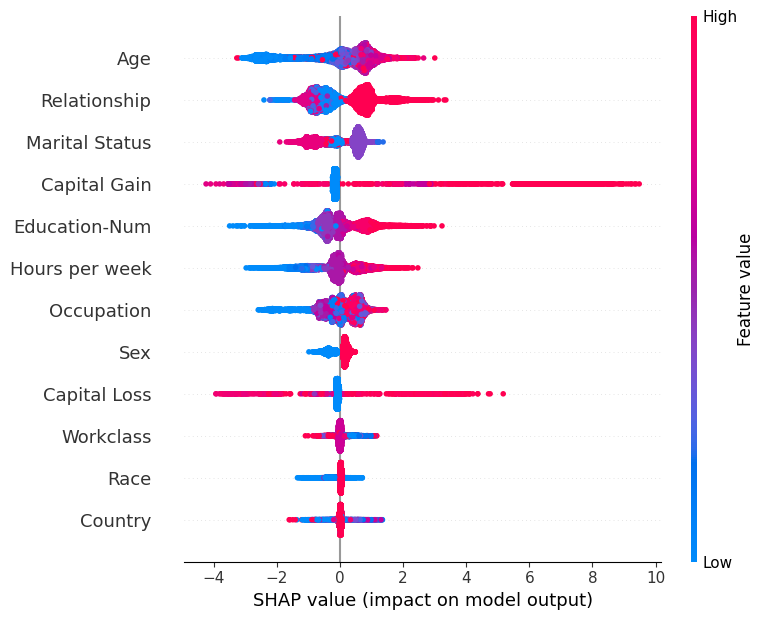

In [16]:
# Visualize SHAP with Summary Plot
shap.summary_plot(shap_values, X_test)

### How to Interpret - SHAP Summary Plot

The Summary Plot is a beeswarm plot. We can see the features listed on the left side of the plot. The bottom shows the SHAP value, which is the impact on the model output.

* For classification models, especially binary classifiers, a negative SHAP value indicates that the feature is contributing to lowering the probability of the positive class, or increasing the probability of the negative class, (<=50k).

* Postive SHAP values indicate that the feature is contributing to increasing the probability of the positive class (>50k)

* Whether the value of the feature is low or high is shown by the color, with low feature values in blue and high feature values shown in red. This is normalized by feature.

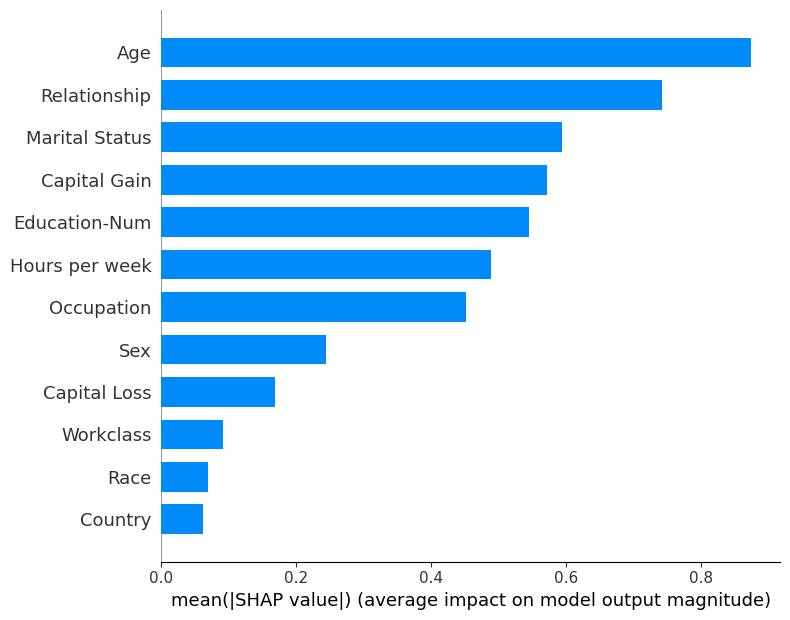

In [17]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

### How to Interpret - SHAP Bar chart

This plot takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.

We can visualize the largest contributors more globally with this plot.

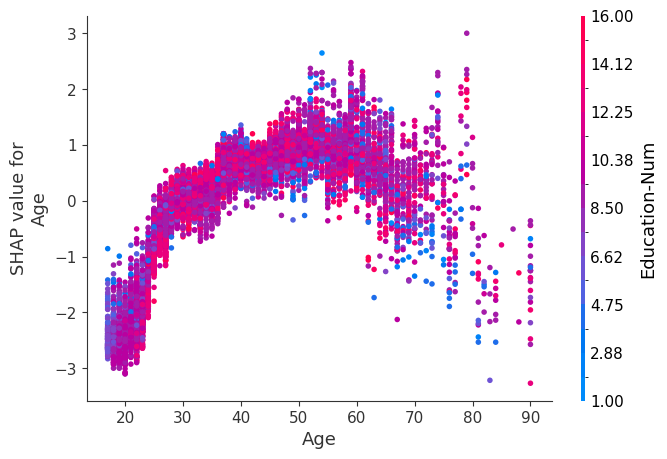

In [18]:
# Visualize SHAP with Dependence Plot
shap.dependence_plot('Age', shap_values, X_test)

### How to Interpret - SHAP Dependence Plot

SHAP dependence plots show the effect of a single feature across the whole dataset. They plot a feature’s value vs. the SHAP value of that feature across many samples. SHAP dependence plots may look similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions.
[Source](https://shap-lrjball.readthedocs.io/en/latest/example_notebooks/tree_explainer/Census%20income%20classification%20with%20XGBoost.html#SHAP-Dependence-Plots)

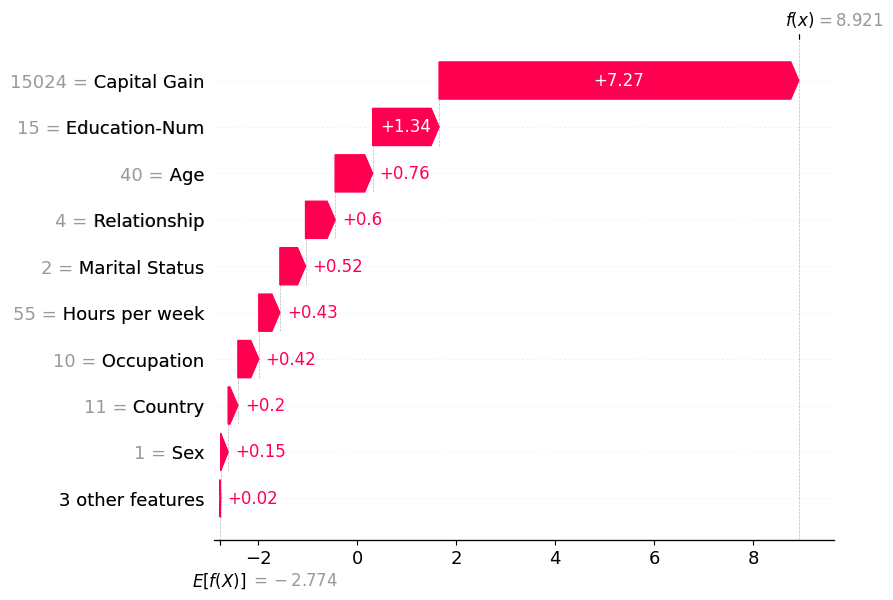

In [19]:
# Visualize an instance with a waterfall plot of the SHAP values

# Choose a sample for explanation
idx = 100

# Plot waterfall plot
shap.plots.waterfall(shap_values_exp[idx])

#### How to Interpret - SHAP Waterfall Plot

You can visualize the SHAP values for an instance of interest. For an instance of interest, you can see the SHAP values and their contribution to the prediction for that instance.

On the left side of the feature names are the specific feature values for the instance of interest


---



## ICE Plots 🧊

Individual Conditional Expectation (ICE) plots one line per instance that displays how the instance’s prediction changes when a feature changes [Paper, 2014](https://arxiv.org/pdf/1309.6392)

**How it Works**
1. Select instance and feature of interest
2. Keep all other features the same, create variants of the instance by replacing the feature’s value with values from a grid
3. Make predictions with the black box model for newly created instances
4. You now have a set of points for an instance with the feature value from the grid and the respective predictions



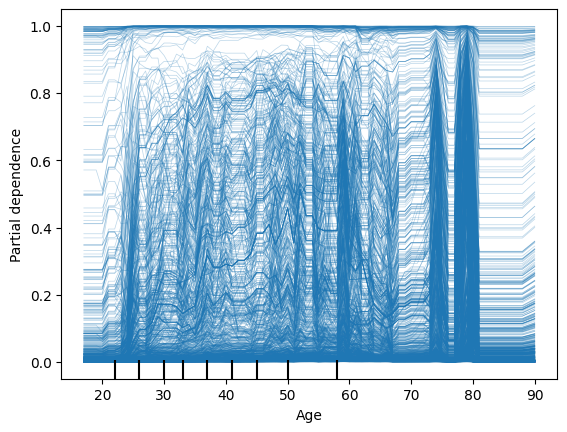

In [20]:
# Choose the feature of interest
features = ["Age"]

# Use PartialDependenceDisplay to display the ICE plot
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='individual') #kind='individual'

#### Partial Dependence Plot (Global Explanation 🌎)

A Partial Dependence Plot (PDP or PD) shows the marginal effect one or two features have on the predicted outcome of a model [Paper, 2001](https://jerryfriedman.su.domains/ftp/trebst.pdf)

* It is the average of the lines of an ICE plot!
* Can show the relationship between a feature and the target


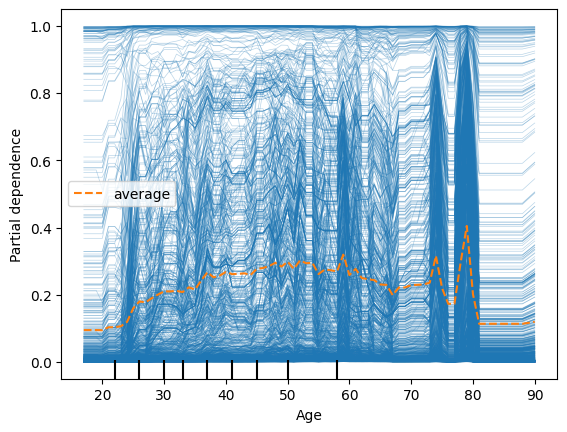

In [21]:
# Use PartialDependenceDisplay to display the ICE plot and the PDP overlayed on top

PartialDependenceDisplay.from_estimator(model, X_test, features, kind='both') #kind='both'

#### Centered ICE plots (c-ICE) ⚖️
We can center the curves at a certain point in the feature and display only the difference in the prediction to this point

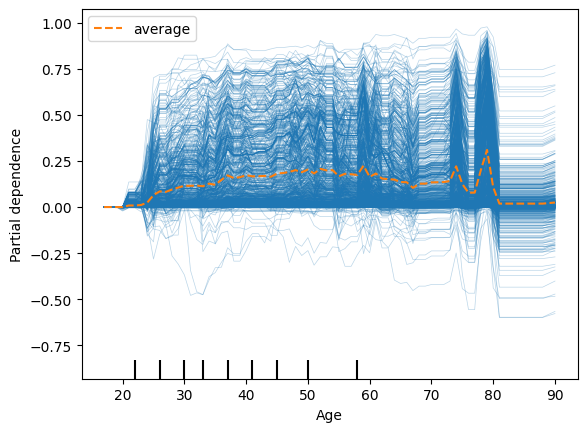

In [22]:
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='both', centered=True)

#### ICE Plot using numpy

We can also use numpy to compute ICE plots. Scikit-learn does not support looking at individual instances in their PartialDependenceDisplay, so if we want to look at individual instances rather than all of the instances, we will need to code the plots ourselves using numpy and matplotlib.

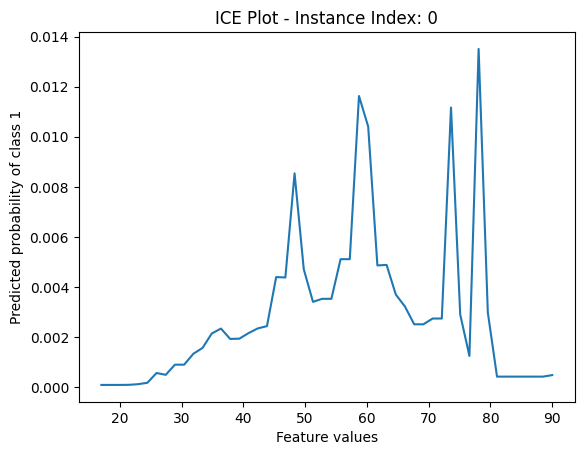

In [23]:
# Choose the instance and feature for which you want to plot the ICE plot
instance_index = 0  # Choose the index of the instance you want to visualize
feature_index = 0  # Let's look at "Age"

# Create feature grid
feature_values = np.linspace(np.min(X.iloc[:, feature_index]), np.max(X.iloc[:, feature_index]), num=50)

# Initialize array to store average predictions
average_predictions = np.zeros_like(feature_values)

# Extract the instance of interest
instance = X.iloc[[instance_index]]

# Duplicate the instance to modify feature values
instance_modified = instance.copy()

# Loop over feature values
for i, value in enumerate(feature_values):
    # Set the chosen feature to the current value for the instance:
    instance_modified.iloc[:, feature_index] = value

    # Predict using the modified instance:
    prediction = model.predict_proba(instance_modified)[:, 1]

    # Store the prediction for the current feature value:
    average_predictions[i] = prediction.item()

# Plot the ICE plot
plt.plot(feature_values, average_predictions)
plt.xlabel(f'Feature values')
plt.ylabel('Predicted probability of class 1')
plt.title(f'ICE Plot - Instance Index: {instance_index}')
plt.show()

#### How to Interpret - ICE Plot

For the instance demonstrated above, as age increases, the predicted probability of >=50k increases. There is interesting behavior around 80 years old for this instance.

Try another instance yourself to see how the ICE plot and interpretation changes across instances!